In [402]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from IPython import display
%matplotlib inline


from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report, roc_auc_score, auc
from sklearn.model_selection import KFold, train_test_split

In [288]:
from keras.layers import Dense
# были некоторые загводздки с Dense слоем, костылем беру из кераса, т.к. итак много времени на дебаг потратил

Напишем DFS, честно признав, что опираемся на гугл и реалзиацию статьи от авторов

In [417]:
data = pd.read_csv("Downloads/train (1).csv")

In [125]:
np.random.seed(777)

X = data[data.columns[:-1]].values
y = data.y.values

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [5]:
class WeightLayer:
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out 

In [184]:
import os

In [393]:
class DFS:
    def __init__(self, input_shape, dense_sizes=[64, 64, 32]):
        self.input_shape = input_shape        
        with tf.variable_scope('dfs') as scope:
            self.weight_layer = WeightLayer(input_shape, 'weighted_layer')
            self.dense_layers = [Dense(x, activation=tf.nn.relu) for x in dense_sizes] + [Dense(2, activation=None)] # copypasted hack
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                _weight_layer = self.weight_layer(inp)
                next_var = _weight_layer
                for layer in self.dense_layers:
                    next_var = layer(next_var)
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out


In [265]:
class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}

In [405]:
class DFS_trainboard:
    def __init__(self,
                 feature_mask,
                 session,
                 lambda_1=0.003,
                 lambda_2=0.2,
                 alpha_1=0.00001,
                 alpha_2=0.05,
                 dense_sizes = [64, 64, 32]):
        self.session = session
        self.feature_mask = feature_mask
        self.n_features = self.feature_mask.sum()
  
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        self.dense_sizes = dense_sizes
        
        self.ready = False

        
    def __get_weighted_layer_regularization_term(self, model, alpha):
        with tf.variable_scope("weight_reg"):
            return (1-alpha) * tf.reduce_sum(tf.abs(model.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(model.weight_layer.w))

    
    def __get_dense_layers_regularization_term(self, model, alpha):
        with tf.variable_scope("dense_reg"):
            r_t = 0
            for layer in model.dense_layers:
                r_t += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))

            return r_t
             
        
    def run_analyzer(self, X_train, y_train, X_test, y_test, max_epochs, batch_size=64, warm_up=40, early_stop=20):
        self.train_ce_losses = []
        self.val_ce_losses = []
        self.val_auc_scores = []
        self.class_weights = {0.: (y_train == 0).sum() / y_train.shape[0], 1.: (y_train == 1).sum() / y_train.shape[0]}
        self.val_weights = np.array([self.class_weights[y] for y in y_test])
        self.val_weights = np.array([self.class_weights[y] for y in y_test])


        with tf.variable_scope('analyzer') as net_scope:
            self.inp = tf.placeholder(tf.float32, [None, self.n_features])
            self.model = DFS(self.n_features, self.dense_sizes)
                 
            self.logits, self.out = self.model(self.inp)
            self.target = tf.placeholder(tf.float32, [None])
            self.loss_weights = tf.placeholder(tf.float32, [None])
            self.cross_entropy = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(self.target, tf.int32), 2),
                                                                 self.logits,
                                                                 weights=self.loss_weights)
            self.features_weights_regularization = \
                self.lambda_1 * self.__get_weighted_layer_regularization_term(self.model, self.lambda_2) 
            self.network_weights_regularization = \
                self.alpha_1 * self.__get_dense_layers_regularization_term(self.model, self.alpha_2)
            
            self.optimizer = tf.train.AdamOptimizer()

            self.loss = self.cross_entropy + self.features_weights_regularization + self.network_weights_regularization
            self.train_step = self.optimizer.minimize(self.loss, var_list=tf.trainable_variables())

        self.uninitialized_vars = []
        for var in tf.all_variables():
            try:
                sess.run(var)
            except tf.errors.FailedPreconditionError:
                self.uninitialized_vars.append(var)

        init_new_vars_op = tf.initialize_variables(self.uninitialized_vars)
        sess.run(init_new_vars_op)
        
        self.net_scope = net_scope

        for epoch in range(max_epochs):
            train_ce_loss = 0

            for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_train, y_train, batch_size)):
                batch_weights = np.array([self.class_weights[y] for y in batch_y])

                batch_loss = self.session.run([self.train_step, self.cross_entropy],
                                      feed_dict={self.inp : batch_X[:,self.feature_mask],
                                                 self.target: batch_y,
                                                 self.loss_weights:batch_weights})

                train_ce_loss += batch_loss[1] * batch_X.shape[0]


            val_ce_loss = self.session.run(self.cross_entropy,
                                           feed_dict={self.inp : X_test[:,self.feature_mask],
                                                      self.target: y_test,
                                                      self.loss_weights : self.val_weights})
            
            val_pred = self.session.run(self.out, feed_dict={self.inp : X_test[:,self.feature_mask]})
            val_pred = val_pred[:, 1]
            val_auc_score = roc_auc_score(y_test, val_pred) 

            self.val_ce_losses.append(val_ce_loss)
            self.val_auc_scores.append(val_auc_score)
            self.train_ce_losses.append(train_ce_loss / X_train.shape[0])
            f, (pic1, pic2) = plt.subplots(2,1,figsize = (15,15))
            display.clear_output(wait=True)
            pic1.plot(self.train_ce_losses[0:], label='train cross entropy')
            pic1.plot(self.val_ce_losses[0:], label = 'val cross entropy')

            pic2.plot(self.val_auc_scores[:], label='val_auc', color='mediumvioletred')
            pic1.legend()
            pic2.legend()
            plt.show()

            if epoch > warm_up:
                if np.argmax(np.array(self.val_auc_scores[-early_stop:])) == 0:
                    print(f"Early stopped in {epoch} epoch")
                    break

def iterate_minibatches(x, y, batchsize, shuffle=True):
    '''
    copypaste from tensorlayer.iterate.minibatches
    '''
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

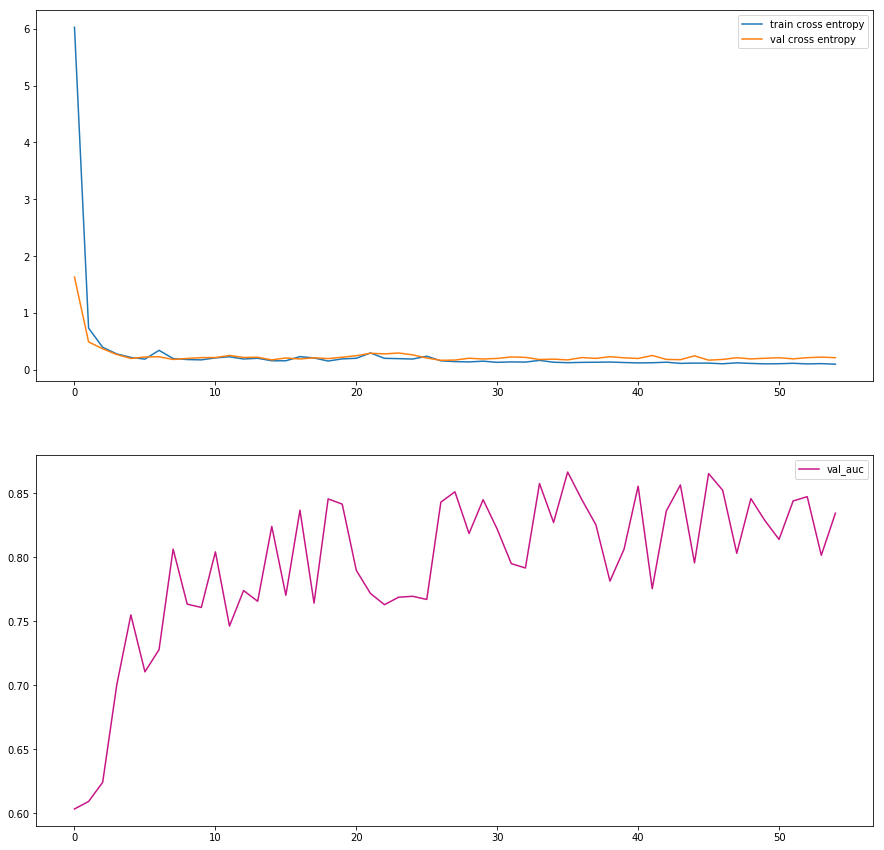

Early stopped in 54 epoch


In [406]:
tf.reset_default_graph()
sess = tf.Session()

dfs = DFS_trainboard(np.ones(X.shape[1]).astype(bool), sess)
dfs.run_analyzer(X_train, y_train, X_test, y_test, 100)

In [407]:
print("Best AUC-ROC:", max(dfs.val_auc_scores))

Best AUC-ROC: 0.8667008196721311


Модель работатает крайне неустойчиво, сетка то очень сильно перееобучается, то работает приемлимо. Вероятно, это связано с природой данных, а возможно стоит обучать подольше и потюнить гиперпараметры, жалею, что не сохранял в процессе картинки

In [369]:
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet

Возьмем фичи с наиболее значимыми коэффициентами из линейной модели и посмотрим, насколько они совпадут с фичами от DFS

In [391]:
lin_model = LogisticRegression(penalty='l1', C=0.02, random_state=2)

lin_model.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [392]:
lin_model = np.sort(np.where(lin_model.coef_[0] != 0)[0])

In [390]:
len(lin_model)

0

Оценим по топ-100:

In [366]:
dfs_best_features = np.argsort(sess.run(dfs.model.weight_layer.w))[::-1][:100]

In [367]:
len(set(lin_model[:100]) & set(dfs_best_features))

34

Довольно мало все равно

In [116]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import LinearSVC

In [408]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", C=0.02))),
  ('classification', RandomForestClassifier(n_estimators=30, max_depth=4))
])

In [409]:
CV_tests(X, y, model=clf)

valid aur_roc: 0.81551
valid aur_roc: 0.78088
valid aur_roc: 0.84877
valid aur_roc: 0.87859
valid aur_roc: 0.84347


In [ ]:
Попробуем еще вот такой адский спосо


_керасом пользоваться != писать сетки_